In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# **Data Preprocessing and Exploration**

In [2]:
P_Sales = pd.read_csv("Pizza_Sale - pizza_sales.csv")
P_Sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [3]:
P_Ingredients = pd.read_csv("Pizza_ingredients - Pizza_ingredients.csv")
P_Ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [4]:
print(P_Sales.info())
print('----------------------------------------------------')
print(P_Ingredients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 colum

In [5]:
print(P_Sales.shape,'\n')

null_data = P_Sales.isnull().sum()
missing_percentage = (P_Sales.isnull().sum() / len(P_Sales)) * 100
data_types = P_Sales.dtypes[null_data[null_data>0].index]
unique_counts = P_Sales.nunique()[null_data[null_data>0].index]

# Creating a DataFrame to hold the count, percentage, Datatype and Unique Values of null values side by side
missing_info = pd.DataFrame({'Null Values': null_data[null_data>0], 
                             'Percentage': missing_percentage[null_data > 0],
                             'Data Type': data_types,
                             'Unique Values': unique_counts
                             
                             })

print(missing_info,'\n')

print('------------------------------------------------------------------------')

print(P_Ingredients.shape,'\n')

null_data = P_Ingredients.isnull().sum()
missing_percentage = (P_Ingredients.isnull().sum() / len(P_Ingredients)) * 100
data_types = P_Ingredients.dtypes[null_data[null_data>0].index]
unique_counts = P_Ingredients.nunique()[null_data[null_data>0].index]

# Creating a DataFrame to hold the count, percentage, Datatype and Unique Values of null values side by side
missing_info = pd.DataFrame({'Null Values': null_data[null_data>0], 
                             'Percentage': missing_percentage[null_data > 0],
                             'Data Type': data_types,
                             'Unique Values': unique_counts
                             
                             })

print(missing_info)



(48620, 12) 

                   Null Values  Percentage Data Type  Unique Values
pizza_name_id               16    0.032908    object             91
total_price                  7    0.014397   float64             56
pizza_category              23    0.047306    object              4
pizza_ingredients           13    0.026738    object             32
pizza_name                   7    0.014397    object             32 

------------------------------------------------------------------------
(518, 4) 

                    Null Values  Percentage Data Type  Unique Values
Items_Qty_In_Grams            4    0.772201   float64             17


pizza_name

In [6]:
# Filling the missing values with it appropriate values

pizza_name_mapping = P_Sales.dropna(subset=['pizza_name_id']).set_index(['pizza_name_id'])['pizza_name'].to_dict()

pizza_name_id_mapping = (P_Sales.dropna(subset=['pizza_name_id']).groupby(['pizza_name', 'pizza_size', 'pizza_category'])['pizza_name_id'].first())

pizza_category_mapping = (P_Sales.dropna(subset=['pizza_category']).groupby(['pizza_name'])['pizza_category'].first())

pizza_ingredients_mapping = (P_Sales.dropna(subset=['pizza_ingredients']).groupby(['pizza_name', 'pizza_name_id'])['pizza_ingredients'].first())


def fill_pizza_name(row):
    if pd.isnull(row['pizza_name']):
        row['pizza_name'] = pizza_name_mapping.get(row['pizza_name_id'])
    return row

def fill_pizza_name_id(row):
    return pizza_name_id_mapping.get((row['pizza_name'], row['pizza_size'], row['pizza_category']), row['pizza_name_id'])

def fill_pizza_category(row):
    return pizza_category_mapping.get((row['pizza_name']), row['pizza_category'])

def fill_pizza_ingredients(row):
    return pizza_ingredients_mapping.get((row['pizza_name'], row['pizza_name_id']), row['pizza_ingredients'])


P_Sales = P_Sales.apply(fill_pizza_name, axis=1)
P_Sales['pizza_name_id'] = P_Sales.apply(fill_pizza_name_id, axis=1)
P_Sales['pizza_category'] = P_Sales.apply(fill_pizza_category, axis=1)
P_Sales['pizza_ingredients'] = P_Sales.apply(fill_pizza_ingredients, axis=1)

P_Sales['total_price'] = np.where(P_Sales['total_price'].isnull(),P_Sales['quantity'] * P_Sales['unit_price'],P_Sales['total_price'])

P_Ingredients['Items_Qty_In_Grams'] = P_Ingredients['Items_Qty_In_Grams'].interpolate(method='linear')

In [7]:
# Checking for duplicates and presence of null values
print("P_Sales")

print("Duplicated Values = ",P_Sales.duplicated().sum())

null_data = P_Sales.isnull().sum()
print("Null Values = ",null_data[null_data>0])

print("\n P_Ingredients")

print("Duplicated Values = ",P_Ingredients.duplicated().sum())

null_data = P_Ingredients.isnull().sum()
print("Null Values = ",null_data[null_data>0])


P_Sales
Duplicated Values =  0
Null Values =  Series([], dtype: int64)

 P_Ingredients
Duplicated Values =  0
Null Values =  Series([], dtype: int64)


In [8]:
# Changing the data type of the order_date column to datetime
def standardize_date(date):
    formats = ['%d/%m/%Y', '%d-%m-%Y']  # List of acceptable date formats
    for fmt in formats:
        try:
            return datetime.strptime(date, fmt).strftime('%d-%m-%Y')
        except ValueError:
            continue
    return date  # Return the original value if all parsing attempts fail

P_Sales['order_date'] = P_Sales['order_date'].apply(standardize_date)

P_Sales['order_date'] = pd.to_datetime(P_Sales['order_date'],format='%d-%m-%Y')


In [9]:
print(P_Sales.info())
print('----------------------------------------------------')
print(P_Ingredients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.5+ MB
None
-----------------------------------

           pizza_id      order_id      quantity    unit_price   total_price
count  48620.000000  48620.000000  48620.000000  48620.000000  48620.000000
mean   24310.500000  10701.479761      1.019622     16.494132     16.821474
std    14035.529381   6180.119770      0.143077      3.621789      4.437398
min        1.000000      1.000000      1.000000      9.750000      9.750000
25%    12155.750000   5337.000000      1.000000     12.750000     12.750000
50%    24310.500000  10682.500000      1.000000     16.500000     16.500000
75%    36465.250000  16100.000000      1.000000     20.250000     20.500000
max    48620.000000  21350.000000      4.000000     35.950000     83.000000


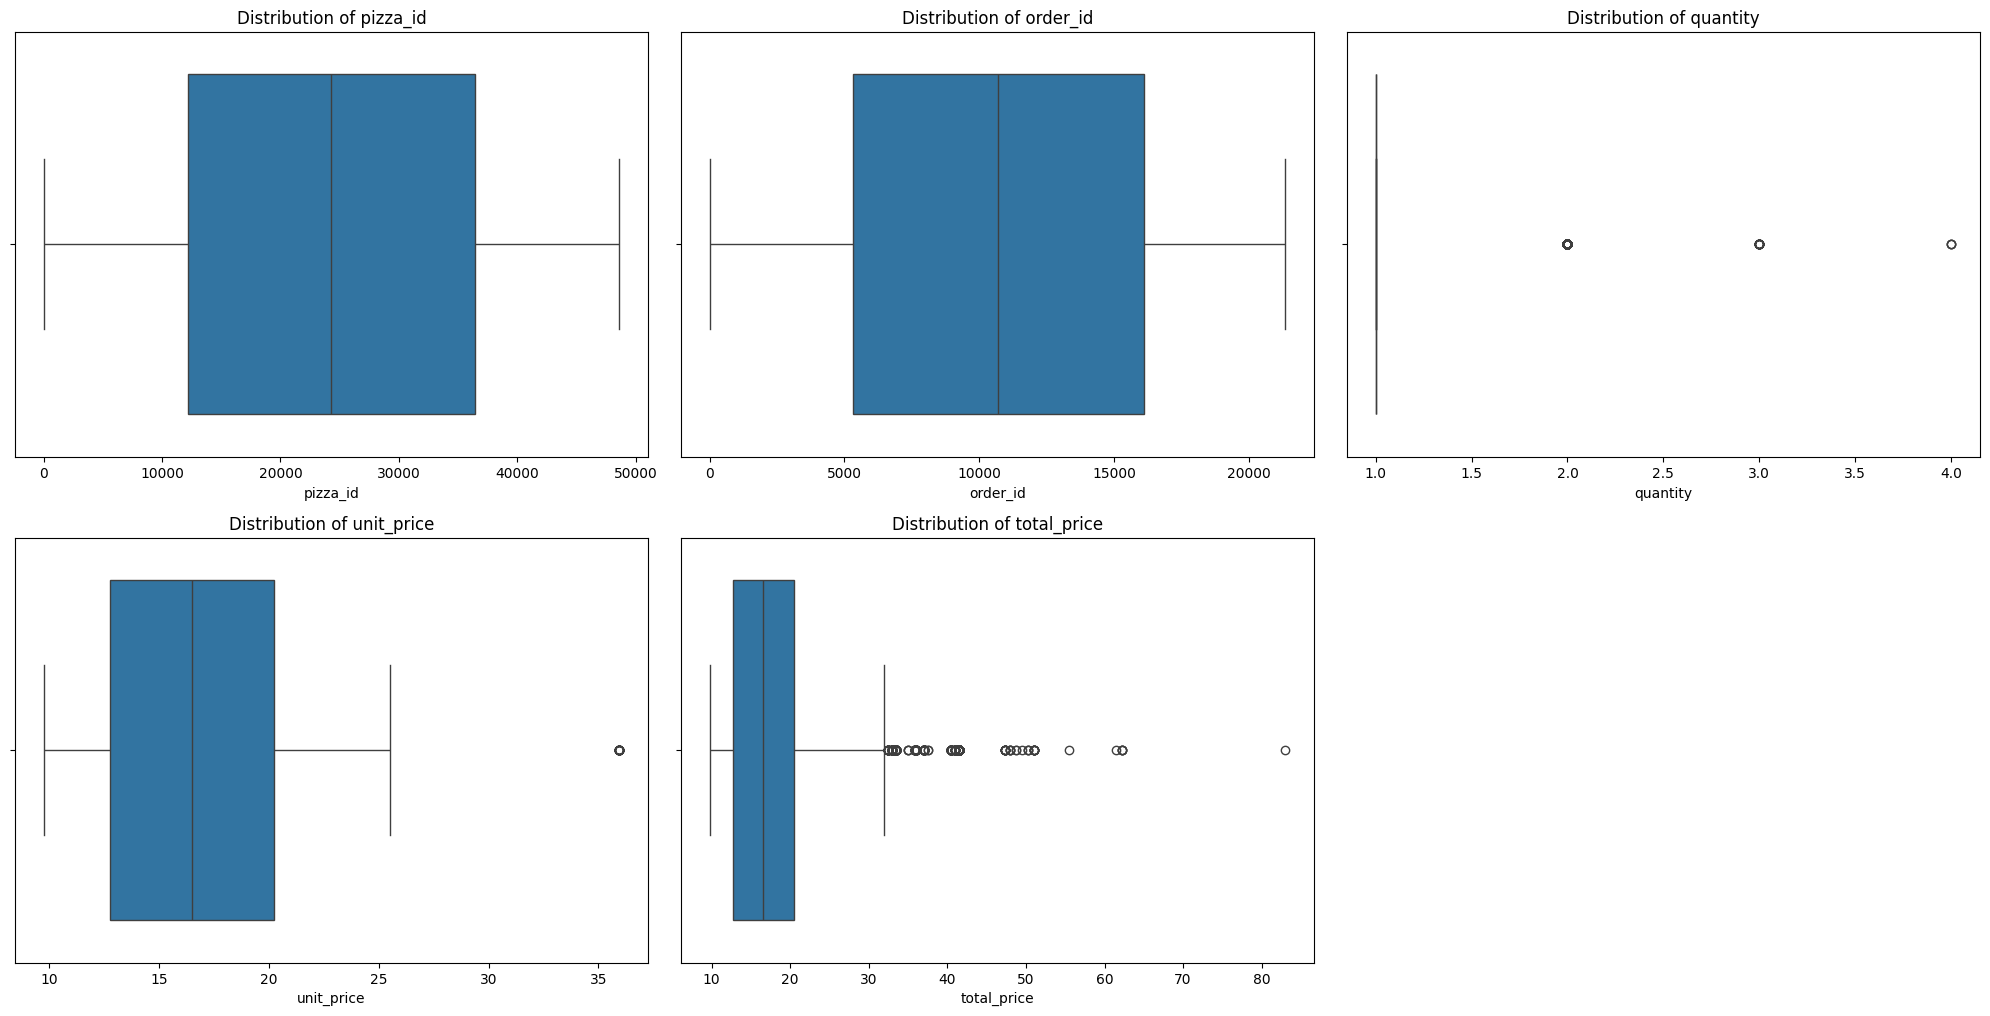

       Items_Qty_In_Grams
count          518.000000
mean            30.511583
std             30.243273
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000


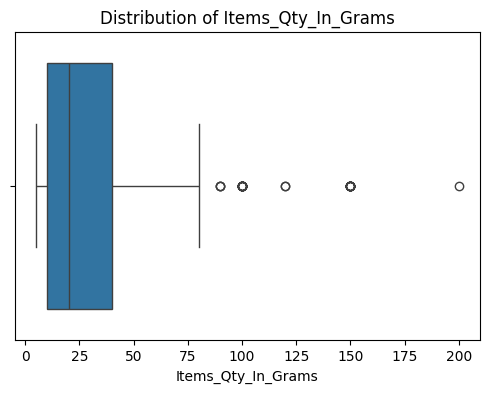

In [10]:
# Checking for outliers in the dataset

numeric_columns = P_Sales.select_dtypes(include=['int64','float64']).columns

print(P_Sales[numeric_columns].describe())

plt.figure(figsize=(20,25))
for i,col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) + 2 // 3, 3, i + 1)
    sns.boxplot(x = P_Sales[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

print(P_Ingredients.describe())

plt.figure(figsize=(6,4))
sns.boxplot(x = P_Ingredients['Items_Qty_In_Grams'])
plt.title('Distribution of Items_Qty_In_Grams')
plt.show()


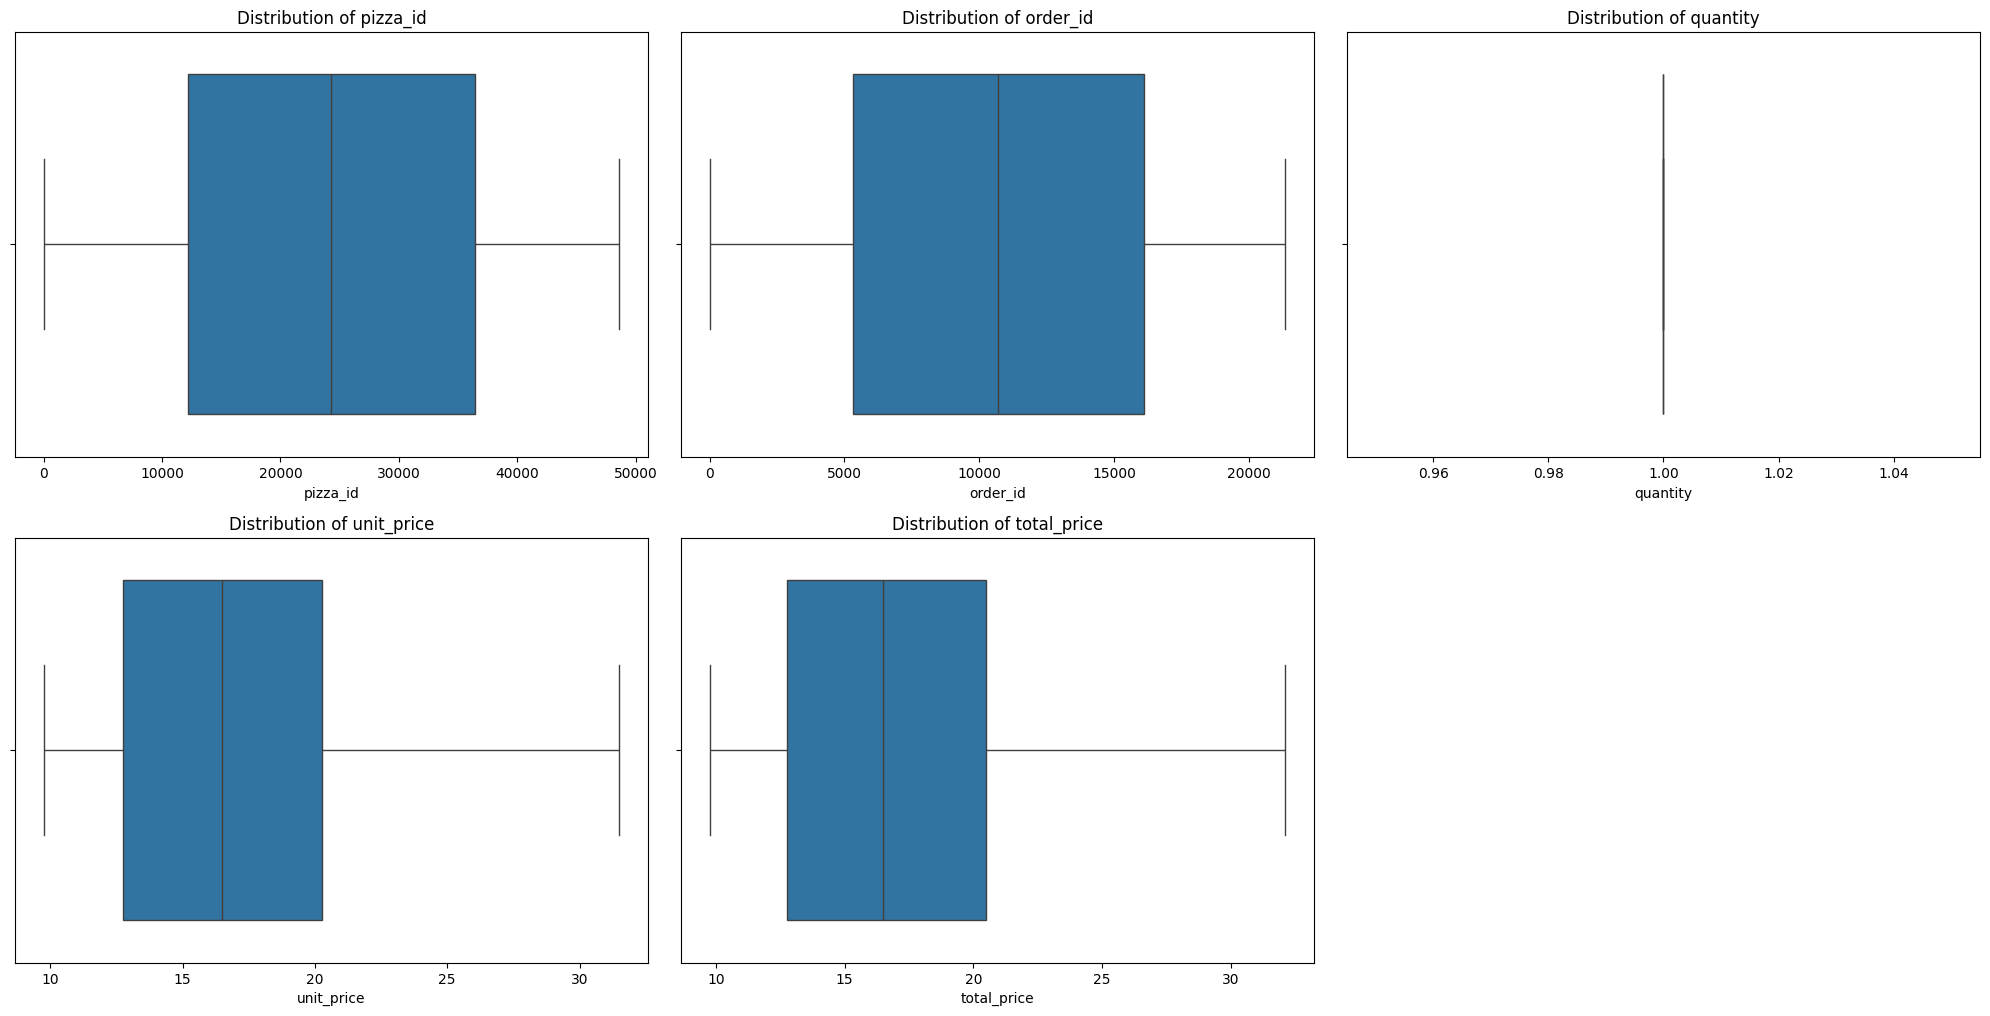

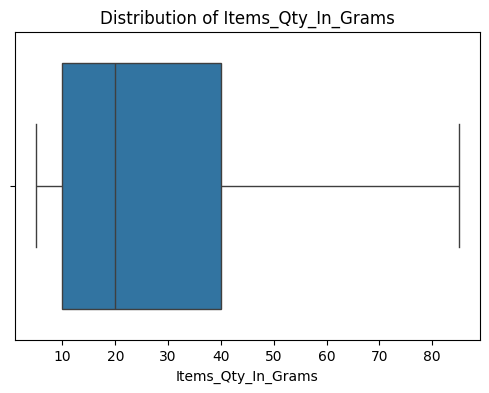

In [11]:
# Calculating the IQR and clipping the outliers

def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip the outliers
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# Clipping outliers in P_Sales
for col in numeric_columns:
    P_Sales = clip_outliers(P_Sales, col)

# plotting the boxplots after clipping the outliers for P_Sales
plt.figure(figsize=(20,25))
for i,col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) + 2 // 3, 3, i + 1)
    sns.boxplot(x = P_Sales[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Clipping outliers in P_Ingredients    
P_Ingredients = clip_outliers(P_Ingredients, 'Items_Qty_In_Grams')

# plotting the boxplots after clipping the outliers for P_Ingredients
plt.figure(figsize=(6,4))
sns.boxplot(x = P_Ingredients['Items_Qty_In_Grams'])
plt.title('Distribution of Items_Qty_In_Grams')
plt.show()

**EDA - Exploratory Data Analysis**

1. Total Sales over Time

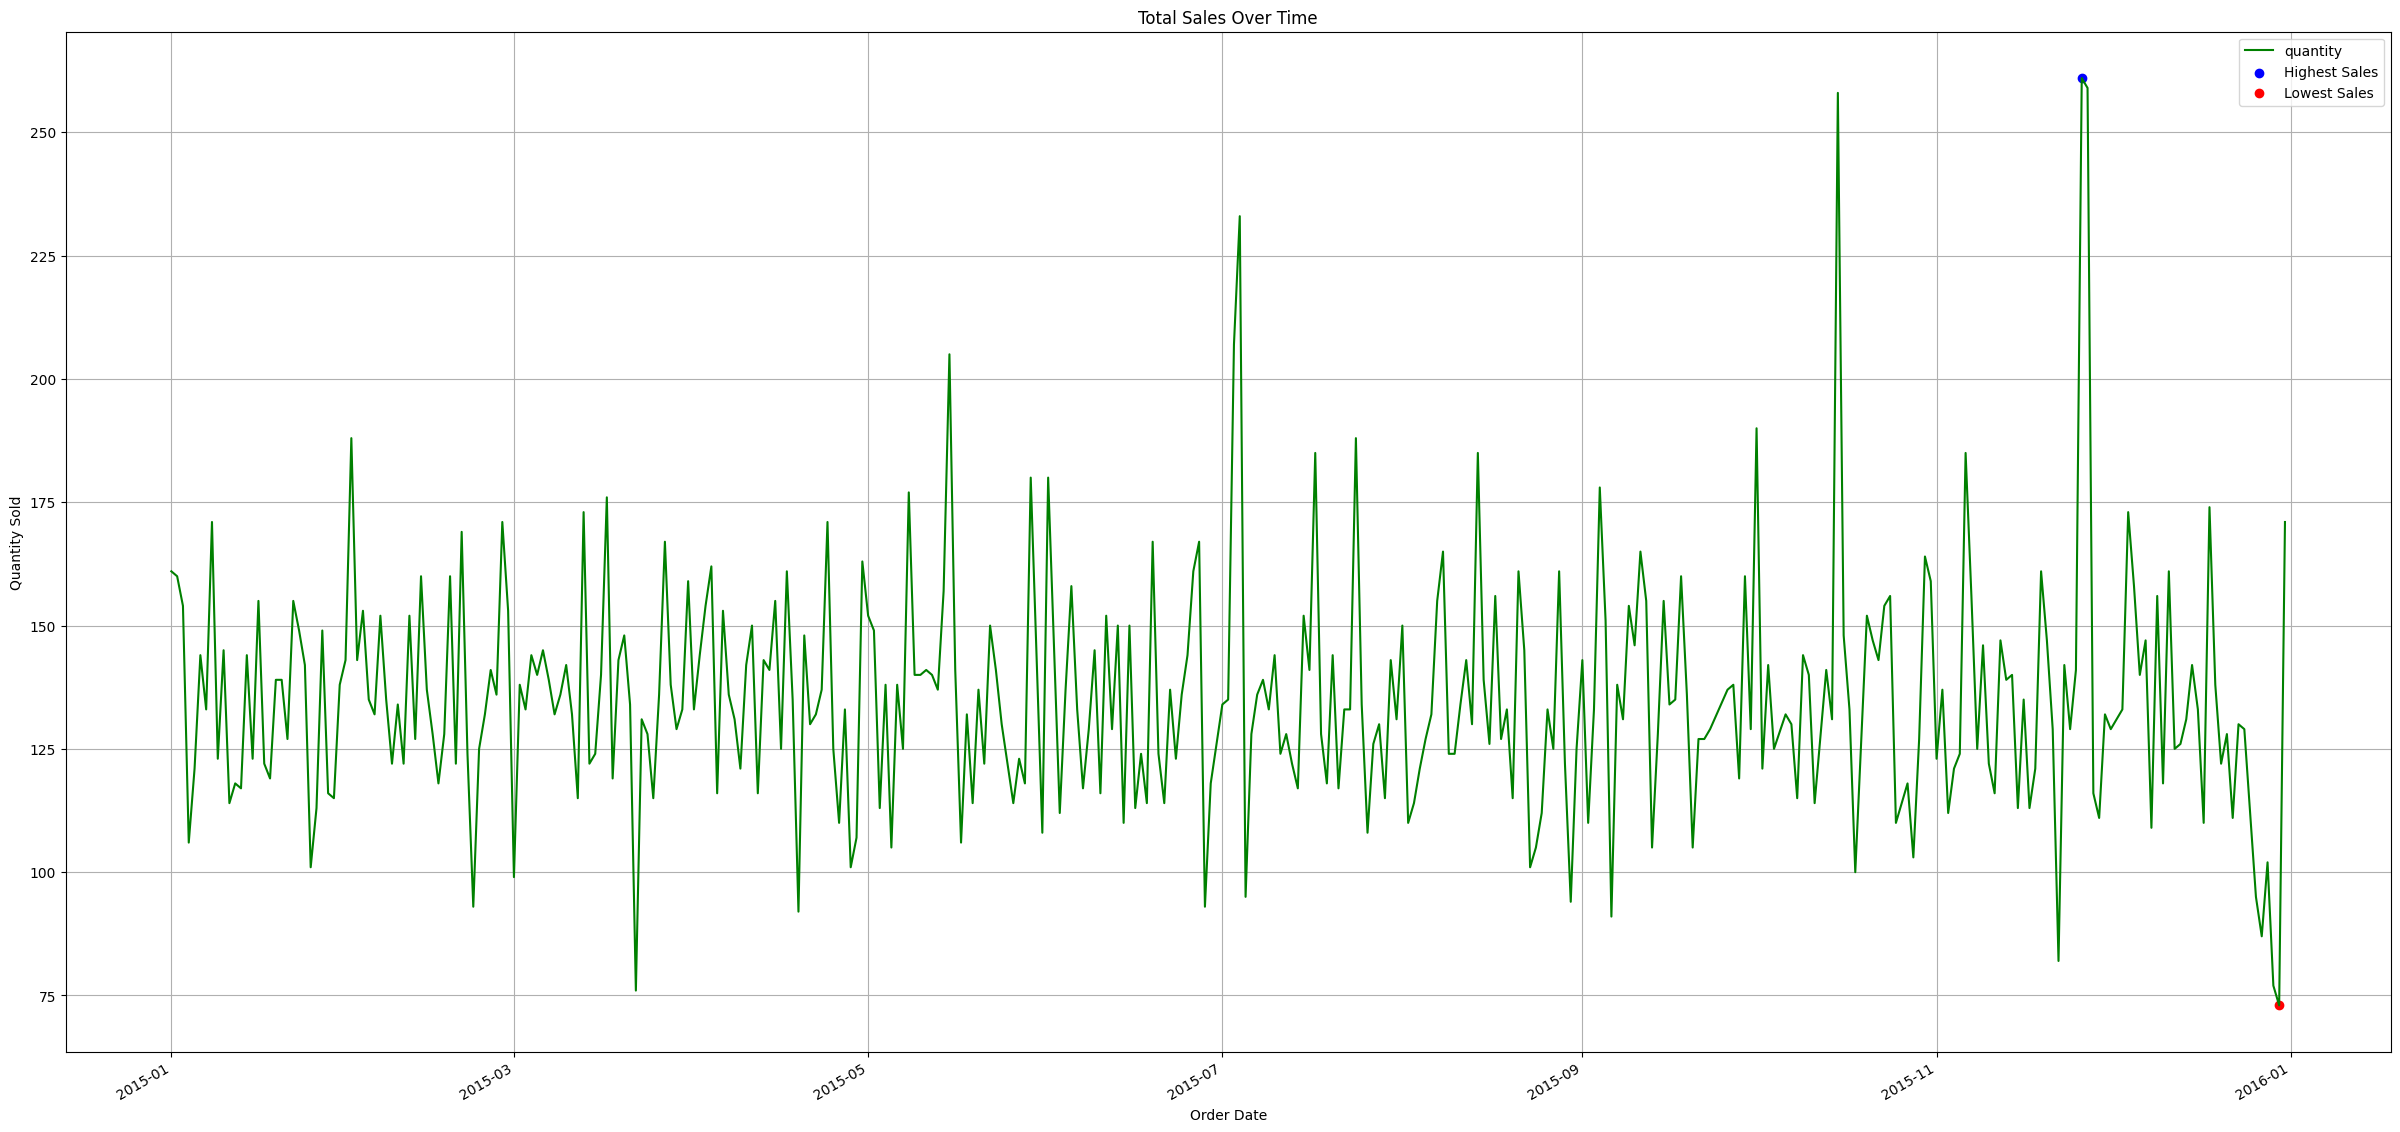

In [12]:
# Group sales data by date
sales_by_date = P_Sales.groupby('order_date')['quantity'].sum()

# Highlighting the highest and lowest sales points
highest_sales_date = sales_by_date.idxmax()
highest_sales_value = sales_by_date.max()
lowest_sales_date = sales_by_date.idxmin()
lowest_sales_value = sales_by_date.min()

# Plot total sales over time
plt.figure(figsize=(30, 15))
sales_by_date.plot(title="Total Sales Over Time", color='green')

# Highlighting the highest and lowest sales points
plt.scatter(highest_sales_date, highest_sales_value, color='blue', label='Highest Sales')
plt.scatter(lowest_sales_date, lowest_sales_value, color='red', label='Lowest Sales')
plt.ylabel("Quantity Sold")
plt.xlabel("Order Date")
plt.grid()
plt.legend()
plt.show()

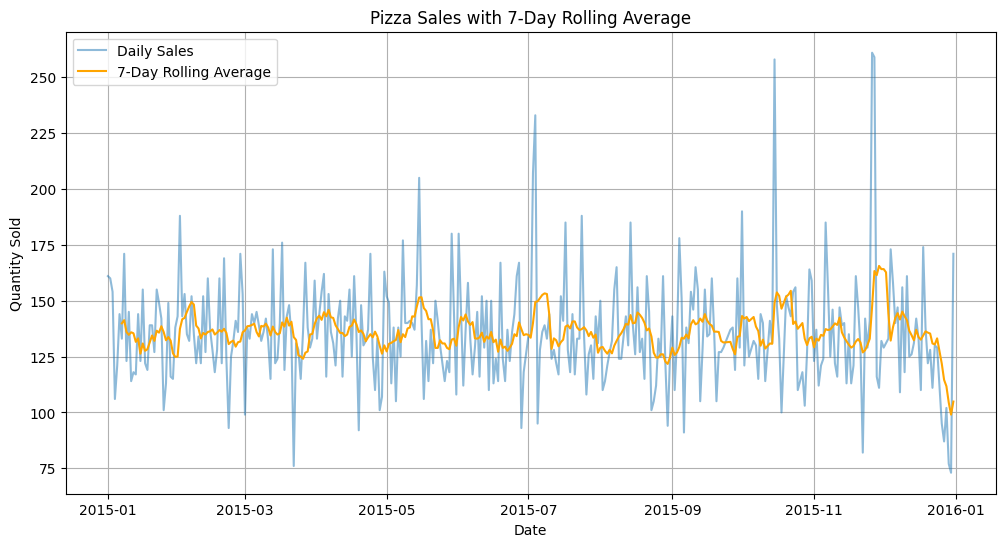

In [13]:
# 7-day rolling average for smoothing daily sales
sales_by_date = P_Sales.groupby('order_date')['quantity'].sum().reset_index()
sales_by_date['rolling_avg'] = sales_by_date['quantity'].rolling(window=7).mean()

# Plot the rolling average
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['order_date'], sales_by_date['quantity'], label='Daily Sales', alpha=0.5)
plt.plot(sales_by_date['order_date'], sales_by_date['rolling_avg'], label='7-Day Rolling Average', color='orange')
plt.title('Pizza Sales with 7-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


2. Monthly Sales Trends

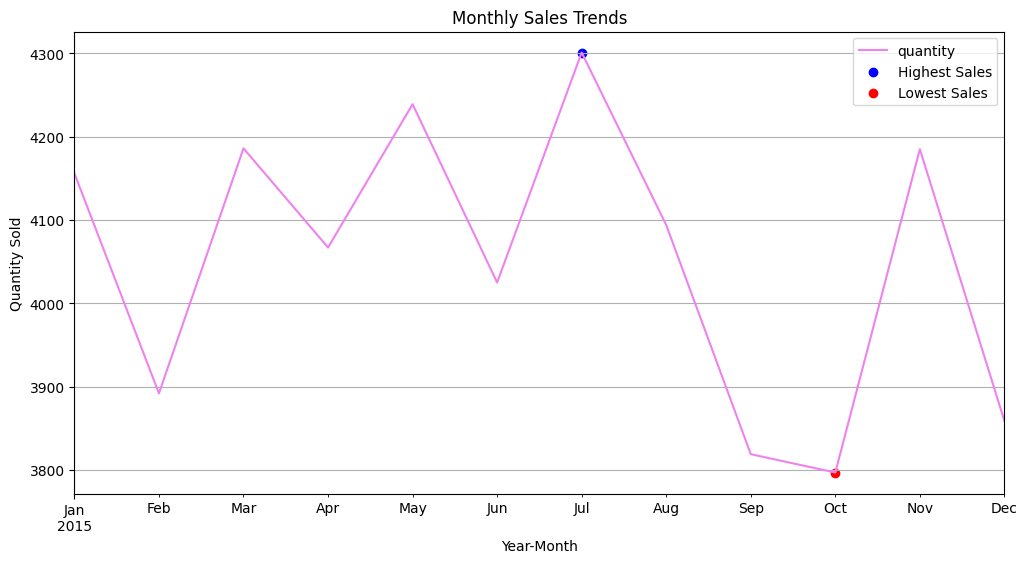

In [14]:
# Extract year and month
P_Sales['year_month'] = P_Sales['order_date'].dt.to_period('M')

# Group by year-month
monthly_sales = P_Sales.groupby('year_month')['quantity'].sum()

# Highlighting the highest and lowest sales points
highest_sales_month = monthly_sales.idxmax()
highest_sales_value = monthly_sales.max()
lowest_sales_month = monthly_sales.idxmin()
lowest_sales_value = monthly_sales.min()

# Plot monthly sales trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(title="Monthly Sales Trends", color='violet')
plt.scatter(highest_sales_month, highest_sales_value, color='blue', label='Highest Sales')
plt.scatter(lowest_sales_month, lowest_sales_value, color='red', label='Lowest Sales')
plt.ylabel("Quantity Sold")
plt.xlabel("Year-Month")
plt.legend()
plt.grid()  
plt.show()

3. Weekly Sales Trend

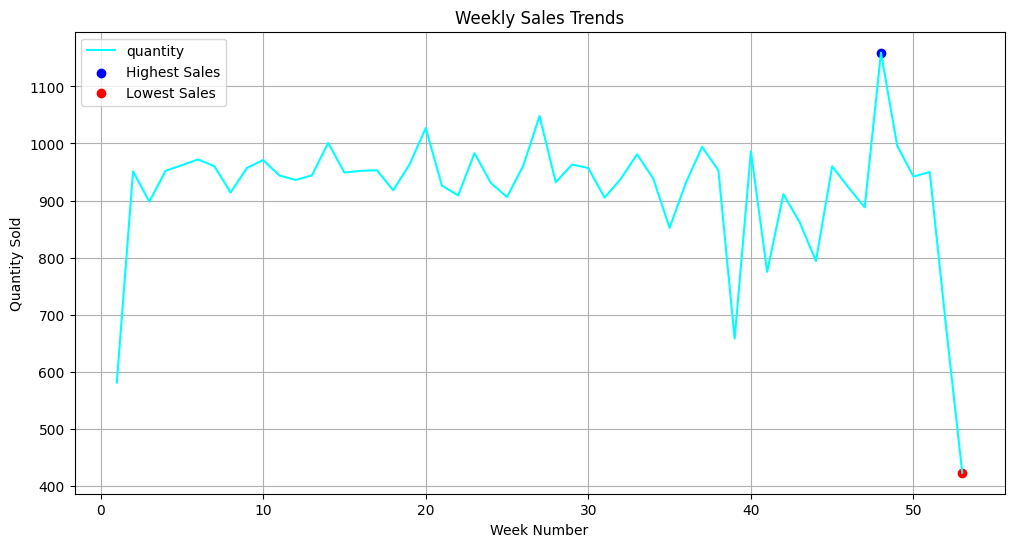

In [15]:
# Pizza Sales high and low in the year with respect to week sales i.e eg. 43rd weeek high sales and 12th week low sales
P_Sales['week_number'] = P_Sales['order_date'].dt.isocalendar().week
weekly_sales = P_Sales.groupby('week_number')['quantity'].sum()

# Highlighting the highest and lowest sales points
highest_sales_week = weekly_sales.idxmax()
highest_sales_value = weekly_sales.max()
lowest_sales_week = weekly_sales.idxmin()
lowest_sales_value = weekly_sales.min()

# Plot weekly sales trends
plt.figure(figsize=(12, 6))
weekly_sales.plot(title="Weekly Sales Trends", color='cyan')
plt.scatter(highest_sales_week, highest_sales_value, color='blue', label='Highest Sales')
plt.scatter(lowest_sales_week, lowest_sales_value, color='red', label='Lowest Sales')
plt.ylabel("Quantity Sold")
plt.xlabel("Week Number")
plt.legend()
plt.grid()
plt.show()

In the year 2015,

53rd week has lowest sales because it consist only 4 days i.e from 28-12-2015 to 31-12-2015 so the total sales is only 423

48th week has highest sales from 23-11-2015 to 29-11-2015, total sales is 1159

-------

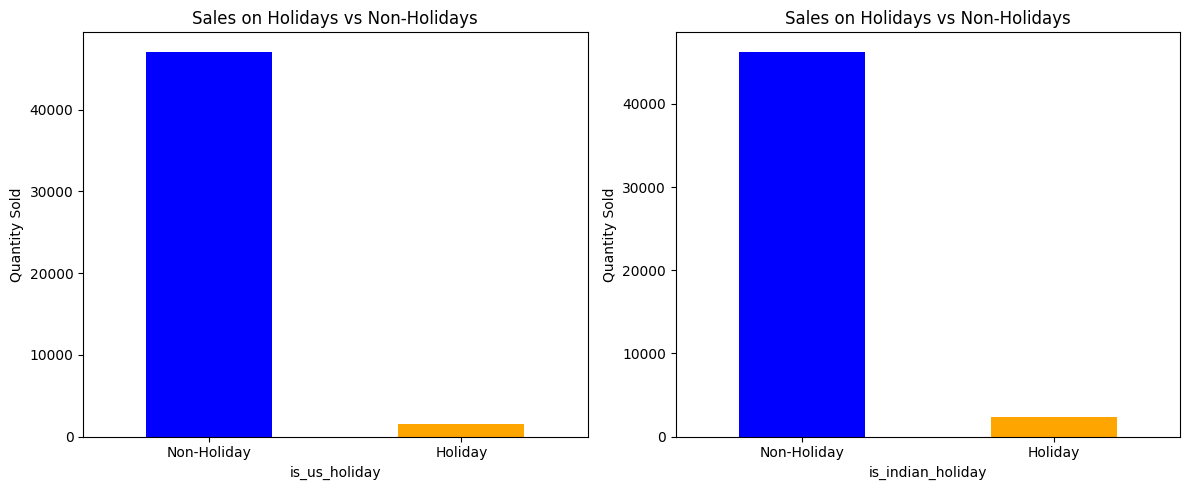

In [16]:
# EDA based on Indian and US holidays
us_holidays = holidays.UnitedStates()  
Indian_Holidays = holidays.India()  

# Separate holiday sales for US and Indian holidays
P_Sales['is_us_holiday'] = P_Sales['order_date'].apply(lambda x: 1 if x in us_holidays else 0)
P_Sales['is_indian_holiday'] = P_Sales['order_date'].apply(lambda x: 1 if x in Indian_Holidays else 0)

# Group sales based on holidays
US_holiday_sales = P_Sales.groupby('is_us_holiday')['quantity'].sum()
INDIAN_holiday_sales = P_Sales.groupby('is_indian_holiday')['quantity'].sum()

plt.figure(figsize=(12,5))

# Plot 1: US Holiday Sales
plt.subplot(1,2,1)
US_holiday_sales.plot(kind='bar', color=['blue', 'orange'])
plt.title('Sales on Holidays vs Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel('Quantity Sold')

# Plot 2: INDIAN Holiday Sales
plt.subplot(1,2,2)
# Plot holiday vs non-holiday sales
INDIAN_holiday_sales.plot(kind='bar', color=['blue', 'orange'])
plt.title('Sales on Holidays vs Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel('Quantity Sold')

plt.tight_layout() 
plt.show()


4. Top 10 most sold pizza and Top 20 most sold pizza in size

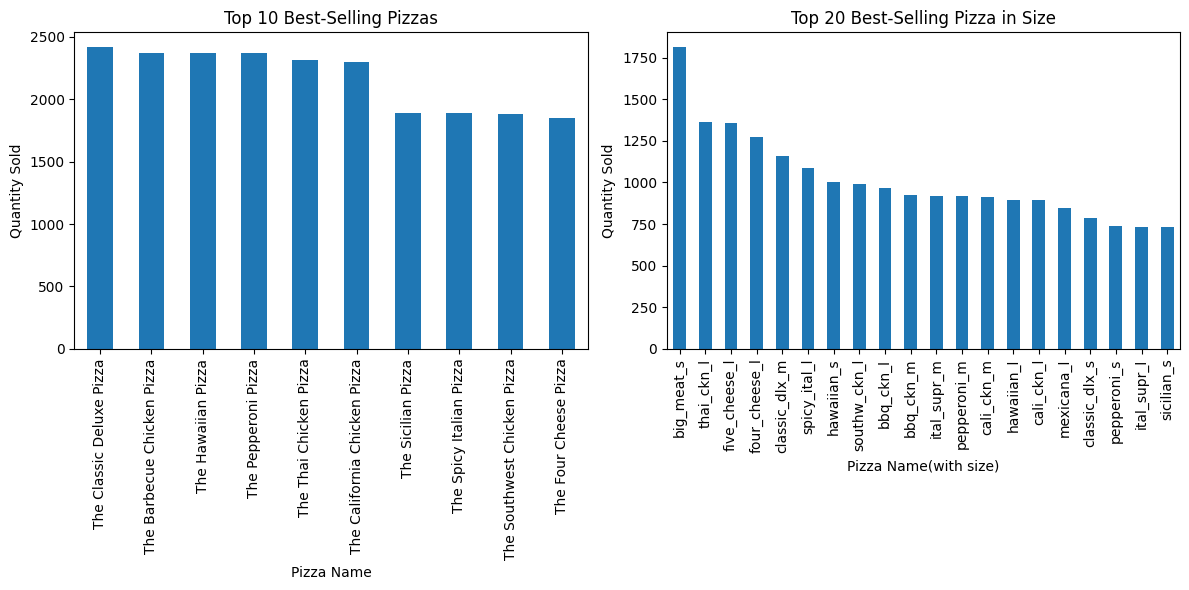

In [17]:
# Top 10 Best-Selling Pizzas
top_pizzas = P_Sales.groupby('pizza_name')['quantity'].sum().nlargest(10)

# Top 20 Best-Selling Pizza name in size
top_pizzas_l_m_s = P_Sales.groupby('pizza_name_id')['quantity'].sum().nlargest(20)

plt.figure(figsize=(12,6))

# Plot 1: Top 10 Best-Selling Pizzas
plt.subplot(1,2,1)
top_pizzas.plot(kind='bar', title="Top 10 Best-Selling Pizzas")
plt.ylabel("Quantity Sold")
plt.xlabel("Pizza Name")
plt.xticks(rotation = 90)

# Plot 2: Top 20 Best-Selling Pizzas in size
plt.subplot(1,2,2)
top_pizzas_l_m_s.plot(kind='bar', title="Top 20 Best-Selling Pizza in Size")
plt.ylabel("Quantity Sold")
plt.xlabel("Pizza Name(with size)")
plt.xticks(rotation = 90)

plt.tight_layout() 
plt.show()


5. Sales of Pizza in Category and Size

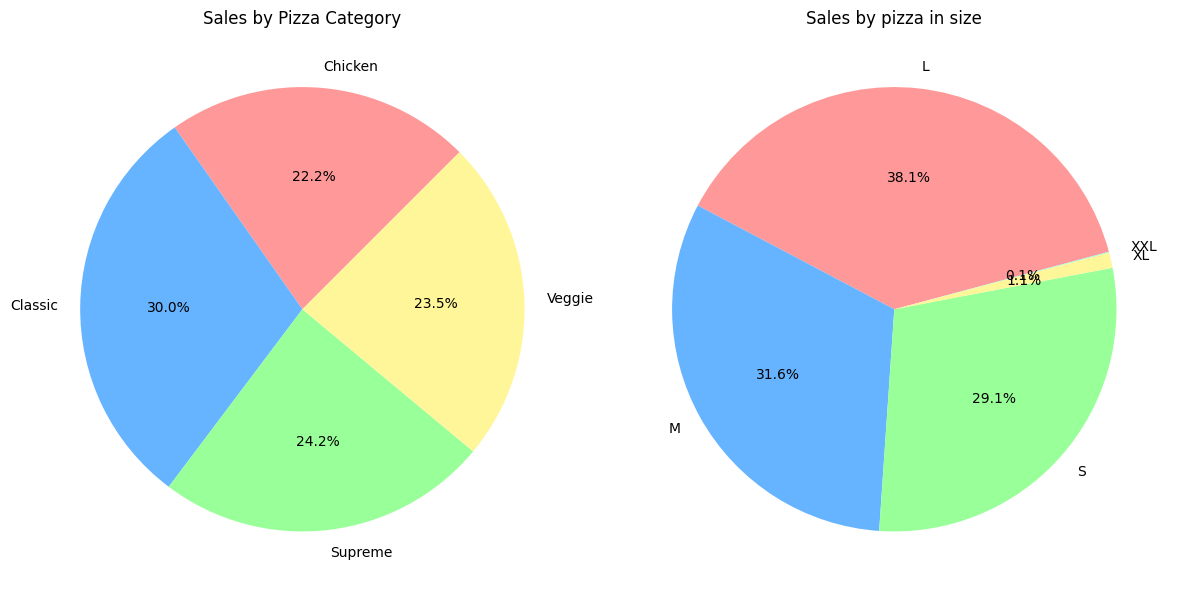

In [18]:
# Total Sales in the category of pizza
category_sales = P_Sales.groupby('pizza_category')['quantity'].sum()

# Total Sales by pizza in size
Pizza_size = P_Sales.groupby('pizza_size')['quantity'].sum()

plt.figure(figsize=(12,10))

# Plot 1: Total Sales in the category of pizza
plt.subplot(1,2,1)
plt.pie(category_sales, labels=category_sales.index,autopct='%1.1f%%',startangle=45, colors=['#ff9999','#66b3ff','#99ff99','#fff699'])
plt.title("Sales by Pizza Category")

# Plot 2: Total Sales by pizza in size
plt.subplot(1,2,2)
plt.pie(Pizza_size, labels=Pizza_size.index,autopct='%1.1f%%',startangle=15, colors=['#ff9999','#66b3ff','#99ff99','#fff699','#99FFDD'])
plt.title("Sales by pizza in size")

plt.tight_layout() 
plt.show()

6. Sales by Hour and Day of the Week

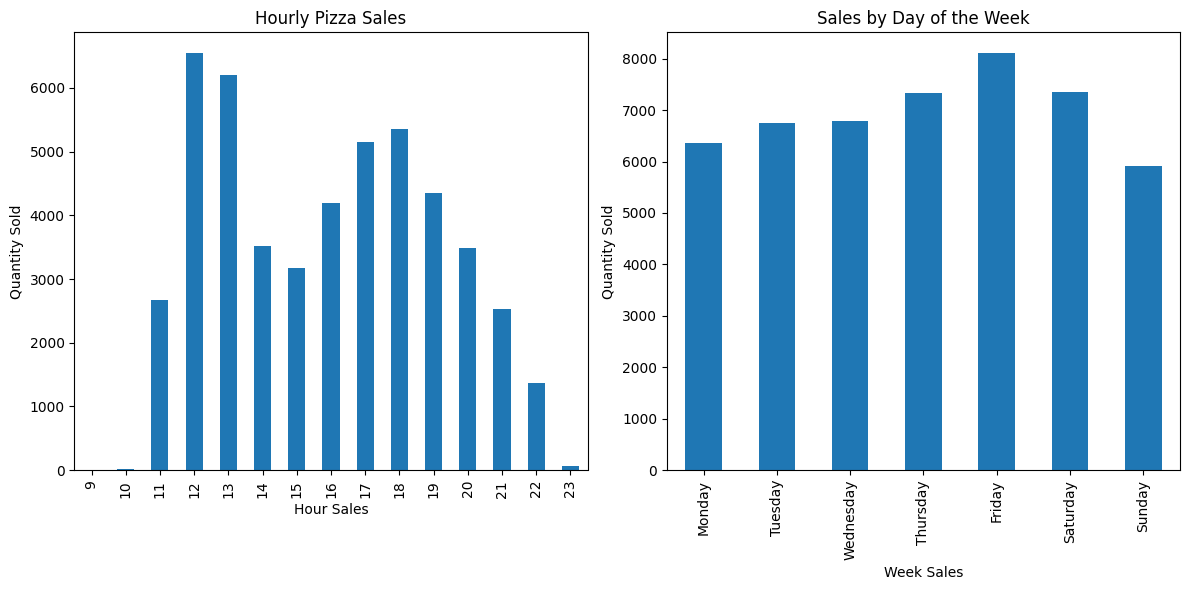

In [19]:
# Sales by hour
P_Sales['hour'] = pd.to_datetime(P_Sales['order_time'], format='%H:%M:%S').dt.hour
hourly_sales = P_Sales.groupby('hour')['quantity'].sum()

# Sales by Day of the Week
P_Sales['day_of_week'] = P_Sales['order_date'].dt.day_name()
weekly_sales = P_Sales.groupby('day_of_week')['quantity'].sum()
weekly_sales = weekly_sales.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


plt.figure(figsize=(12,6))

# Plot 1: Sales by hour
plt.subplot(1,2,1)
hourly_sales.plot(kind='bar', title="Hourly Pizza Sales")
plt.ylabel("Quantity Sold")
plt.xlabel("Hour Sales")

# Plot 2: Total Sales by pizza in size
plt.subplot(1,2,2)
weekly_sales.plot(kind='bar', title="Sales by Day of the Week")
plt.ylabel("Quantity Sold")
plt.xlabel("Week Sales")


plt.tight_layout()
plt.show()

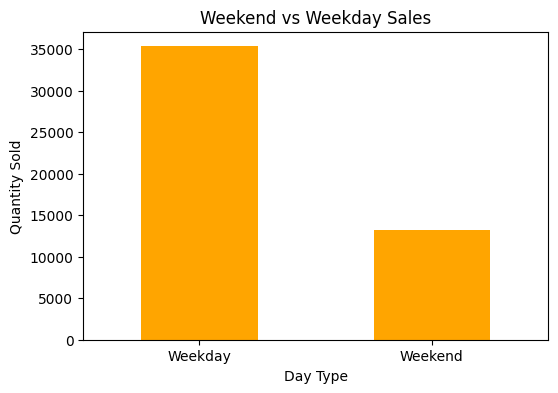

In [20]:
# Sales of pizza in weekdays and weekends
P_Sales['weekend'] = P_Sales['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_sales = P_Sales.groupby('weekend')['quantity'].sum()

# Plot weekend vs weekday sales
weekend_sales.plot(kind='bar', title="Weekend vs Weekday Sales", figsize=(6, 4), color='orange')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel("Quantity Sold")
plt.xlabel("Day Type")
plt.show()


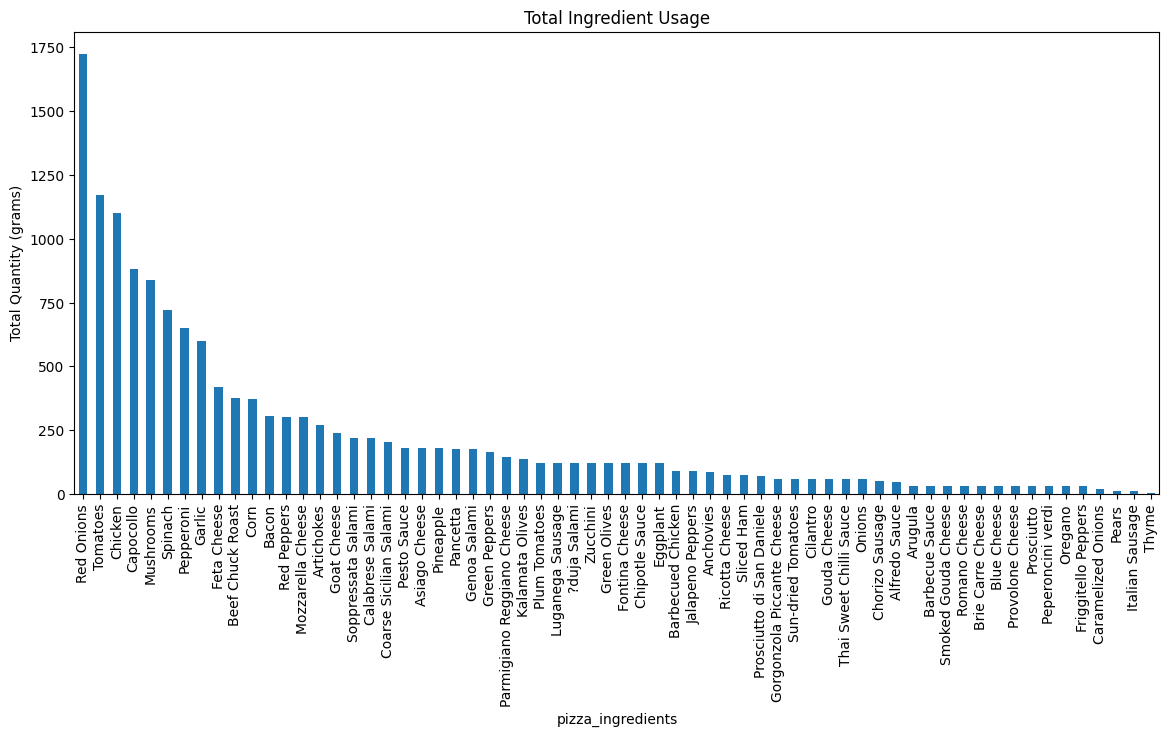

In [21]:
ingredient_usage = P_Ingredients.groupby('pizza_ingredients')['Items_Qty_In_Grams'].sum()
ingredient_usage = ingredient_usage.sort_values(ascending=False)

ingredient_usage.plot(kind='bar', title="Total Ingredient Usage", figsize=(14, 6))
plt.ylabel("Total Quantity (grams)")
plt.show()


In [22]:
# Generate the full date range
full_date_range = pd.date_range(start=P_Sales['order_date'].min(), 
                                end=P_Sales['order_date'].max(), 
                                freq='D')

# Get unique dates from the dataset
existing_dates = set(P_Sales['order_date'].unique())

# Find missing dates
missing_dates = set(full_date_range) - existing_dates

# Convert to a sorted list for readability
missing_dates = sorted(list(missing_dates))

# Print the missing dates
print("Missing Dates:")
for date in missing_dates:
    print(date)

# Convert missing dates to a DataFrame for better analysis
missing_dates_df = pd.DataFrame({'Missing Dates': missing_dates})
missing_dates_df['Weekday'] = missing_dates_df['Missing Dates'].dt.day_name()

# Check frequency of missing dates by weekday
print("\n",missing_dates_df['Weekday'].value_counts())


Missing Dates:
2015-09-24 00:00:00
2015-09-25 00:00:00
2015-10-05 00:00:00
2015-10-12 00:00:00
2015-10-19 00:00:00
2015-10-26 00:00:00
2015-12-25 00:00:00

 Weekday
Monday      4
Friday      2
Thursday    1
Name: count, dtype: int64


# **Sales Prediction**

In [23]:
# Extracting the date features
P_Sales['week_number'] = P_Sales['order_date'].dt.isocalendar().week

P_Sales['month_number'] = P_Sales['order_date'].dt.month

P_Sales['hour'] = pd.to_datetime(P_Sales['order_time'], format='%H:%M:%S').dt.hour

P_Sales['week_day_number'] = P_Sales['order_date'].dt.dayofweek

In [24]:
P_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
 12  year_month         48620 non-null  period[M]     
 13  week_number        48620 non-null  UInt32        
 14  is_us_

In [25]:
Sales = P_Sales.groupby(['pizza_name_id', 'order_date', 'month_number', 'week_number',
                         'week_day_number', 'hour'], as_index=False)['quantity'].sum()
Sales.head()

,pizza_name_id,order_date,month_number,week_number,week_day_number,hour,quantity
0,bbq_ckn_l,2015-01-01,1,1,3,13,2
1,bbq_ckn_l,2015-01-01,1,1,3,15,2
2,bbq_ckn_l,2015-01-01,1,1,3,18,1
3,bbq_ckn_l,2015-01-01,1,1,3,22,1
4,bbq_ckn_l,2015-01-02,1,1,4,15,1


In [26]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44341 entries, 0 to 44340
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pizza_name_id    44341 non-null  object        
 1   order_date       44341 non-null  datetime64[ns]
 2   month_number     44341 non-null  int32         
 3   week_number      44341 non-null  UInt32        
 4   week_day_number  44341 non-null  int32         
 5   hour             44341 non-null  int32         
 6   quantity         44341 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int32(3), int64(1), object(1)
memory usage: 1.7+ MB


In [27]:
# Creating an empty dictionary to store 91 DataFrames
pizza_dfs = {}

# Grouping the Sales DataFrame by pizza_name_id
grouped = Sales.groupby('pizza_name_id')

# Looping through each group and store it as a separate DataFrame
for pizza_id, group in grouped:
    pizza_dfs[pizza_id] = group[['pizza_name_id', 'order_date', 'month_number', 'week_number',
                                 'week_day_number', 'hour', 'quantity']].reset_index(drop=True)

# Checking the first few DataFrames
for key, df in list(pizza_dfs.items())[:5]:  # Display the first 5 DataFrames
    print(f"\nPizza: {key}")
    print(df.head())



Pizza: bbq_ckn_l
  pizza_name_id order_date  month_number  week_number  week_day_number  hour  \
0     bbq_ckn_l 2015-01-01             1            1                3    13   
1     bbq_ckn_l 2015-01-01             1            1                3    15   
2     bbq_ckn_l 2015-01-01             1            1                3    18   
3     bbq_ckn_l 2015-01-01             1            1                3    22   
4     bbq_ckn_l 2015-01-02             1            1                4    15   

   quantity  
0         2  
1         2  
2         1  
3         1  
4         1  

Pizza: bbq_ckn_m
  pizza_name_id order_date  month_number  week_number  week_day_number  hour  \
0     bbq_ckn_m 2015-01-01             1            1                3    14   
1     bbq_ckn_m 2015-01-01             1            1                3    16   
2     bbq_ckn_m 2015-01-01             1            1                3    20   
3     bbq_ckn_m 2015-01-02             1            1                4    12   

In [28]:
# model Selection and evaluation
class PizzaSalesModeling:
    def __init__(self, data):
        self.data = data.copy()  # Creating a copy of the original data
        self.train_data = None
        self.test_data = None
        self.split_data()


    def split_data(self, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        for train_index, test_index in tscv.split(self.data):
            self.train_data = self.data.iloc[train_index].copy()
            self.test_data = self.data.iloc[test_index].copy()


    def evaluate_model(self, model, X_test, y_true):
        X_test = X_test.reshape(-1,1)
        predictions = model.predict(X_test)

        if len(predictions) == len(y_true):
            mape = mean_absolute_percentage_error(y_true, predictions)
            return mape
        else:
            return None
        

    def arima_model(self, order=(1, 1, 1)):
        model = ARIMA(self.train_data['quantity'], order=order)
        model_fit = model.fit()
        return model_fit


    def sarima_model(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)):
        model = SARIMAX(self.train_data['quantity'], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit


    def prophet_model(self):
        self.train_data['ds'] = self.train_data['order_date']
        prophet_data = self.train_data[['ds', 'quantity']].rename(columns={'quantity': 'y'})
        model = Prophet()
        model.fit(prophet_data)
        return model


    def linear_regression_model(self):
        X_train = np.arange(len(self.train_data)).reshape(-1, 1)
        y_train = self.train_data['quantity'].values
        model = LinearRegression()
        model.fit(X_train, y_train)
        return model


    def random_forest_model(self):
        X_train = np.arange(len(self.train_data)).reshape(-1, 1)
        y_train = self.train_data['quantity'].values
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        return model


    def xgboost_model(self):
        X_train = np.arange(len(self.train_data)).reshape(-1, 1)
        y_train = self.train_data['quantity'].values
        model = XGBRegressor()
        model.fit(X_train, y_train)
        return model

    

In [29]:
def print_results(model_name, model_results):
    print(f"Model - {model_name} (MAPE Score)\n")
    for pizza, mape_score in model_results.items():
        print(f"Pizza {pizza} - {mape_score:.5f}")

results = {}

def run_arima():
    results['ARIMA'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.arima_model()
        predictions = trained_model.forecast(steps=len(model.test_data))  # Predict test data
        results['ARIMA'][pizza_id] = mean_absolute_percentage_error(model.test_data['quantity'], predictions)
    print_results('ARIMA', results['ARIMA'])


def run_sarima():
    results['SARIMA'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.sarima_model()
        predictions = trained_model.forecast(steps=len(model.test_data))
        results['SARIMA'][pizza_id] = mean_absolute_percentage_error(model.test_data['quantity'], predictions)
    print_results('SARIMA', results['SARIMA'])


def run_prophet():
    results['Prophet'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.prophet_model()
        future = model.test_data[['order_date']].rename(columns={'order_date': 'ds'})
        forecast = trained_model.predict(future)
        predictions = forecast['yhat'].values
        results['Prophet'][pizza_id] = mean_absolute_percentage_error(model.test_data['quantity'], predictions)
    print_results('Prophet', results['Prophet'])


def run_linear_regression():
    results['Linear Regression'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.linear_regression_model()
        X_test = np.arange(len(model.train_data), len(model.test_data) + len(model.train_data)).reshape(-1, 1)
        results['Linear Regression'][pizza_id] = model.evaluate_model(trained_model, X_test, model.test_data['quantity'])
    print_results('Linear Regression', results['Linear Regression'])


def run_random_forest():
    results['Random Forest'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.random_forest_model()
        X_test = np.arange(len(model.train_data), len(model.test_data) + len(model.train_data)).reshape(-1, 1)
        results['Random Forest'][pizza_id] = model.evaluate_model(trained_model, X_test, model.test_data['quantity'])
    print_results('Random Forest', results['Random Forest'])


def run_xgboost():
    results['XGBoost'] = {}
    for pizza_id, df in pizza_dfs.items():
        model = PizzaSalesModeling(df)
        trained_model = model.xgboost_model()
        X_test = np.arange(len(model.train_data), len(model.test_data) + len(model.train_data)).reshape(-1, 1)
        results['XGBoost'][pizza_id] = model.evaluate_model(trained_model, X_test, model.test_data['quantity'])
    print_results('XGBoost', results['XGBoost'])


In [30]:
run_xgboost()

Model - XGBoost (MAPE Score)

Pizza bbq_ckn_l - 0.26627
Pizza bbq_ckn_m - 0.05737
Pizza bbq_ckn_s - 0.06091
Pizza big_meat_s - 0.12172
Pizza brie_carre_s - 0.02700
Pizza calabrese_l - 0.02334
Pizza calabrese_m - 0.03489
Pizza calabrese_s - 0.00007
Pizza cali_ckn_l - 0.08661
Pizza cali_ckn_m - 0.04421
Pizza cali_ckn_s - 0.01295
Pizza ckn_alfredo_l - 0.01676
Pizza ckn_alfredo_m - 0.05678
Pizza ckn_alfredo_s - 0.00009
Pizza ckn_pesto_l - 0.03295
Pizza ckn_pesto_m - 0.03418
Pizza ckn_pesto_s - 0.02136
Pizza classic_dlx_l - 0.01400
Pizza classic_dlx_m - 0.06607
Pizza classic_dlx_s - 0.04739
Pizza five_cheese_l - 0.06964
Pizza four_cheese_l - 0.24186
Pizza four_cheese_m - 0.05591
Pizza green_garden_l - 0.00005
Pizza green_garden_m - 0.02148
Pizza green_garden_s - 0.33379
Pizza hawaiian_l - 0.06003
Pizza hawaiian_m - 0.03929
Pizza hawaiian_s - 0.27564
Pizza ital_cpcllo_l - 0.04565
Pizza ital_cpcllo_m - 0.01733
Pizza ital_cpcllo_s - 0.02096
Pizza ital_supr_l - 0.05955
Pizza ital_supr_m - 0.259

In [31]:
run_random_forest()

Model - Random Forest (MAPE Score)

Pizza bbq_ckn_l - 0.12268
Pizza bbq_ckn_m - 0.05515
Pizza bbq_ckn_s - 0.06081
Pizza big_meat_s - 0.11900
Pizza brie_carre_s - 0.02667
Pizza calabrese_l - 0.02326
Pizza calabrese_m - 0.03448
Pizza calabrese_s - 0.00000
Pizza cali_ckn_l - 0.09094
Pizza cali_ckn_m - 0.04258
Pizza cali_ckn_s - 0.01282
Pizza ckn_alfredo_l - 0.01667
Pizza ckn_alfredo_m - 0.05607
Pizza ckn_alfredo_s - 0.00000
Pizza ckn_pesto_l - 0.03279
Pizza ckn_pesto_m - 0.03409
Pizza ckn_pesto_s - 0.02128
Pizza classic_dlx_l - 0.03270
Pizza classic_dlx_m - 0.06250
Pizza classic_dlx_s - 0.04520
Pizza five_cheese_l - 0.06597
Pizza four_cheese_l - 0.11170
Pizza four_cheese_m - 0.05556
Pizza green_garden_l - 0.00000
Pizza green_garden_m - 0.02128
Pizza green_garden_s - 0.33967
Pizza hawaiian_l - 0.05890
Pizza hawaiian_m - 0.03881
Pizza hawaiian_s - 0.13474
Pizza ital_cpcllo_l - 0.04398
Pizza ital_cpcllo_m - 0.05419
Pizza ital_cpcllo_s - 0.02083
Pizza ital_supr_l - 0.05856
Pizza ital_supr_m -

In [32]:
run_linear_regression()

Model - Linear Regression (MAPE Score)

Pizza bbq_ckn_l - 0.14978
Pizza bbq_ckn_m - 0.15134
Pizza bbq_ckn_s - 0.08467
Pizza big_meat_s - 0.30511
Pizza brie_carre_s - 0.08579
Pizza calabrese_l - 0.02696
Pizza calabrese_m - 0.11791
Pizza calabrese_s - 0.04819
Pizza cali_ckn_l - 0.18466
Pizza cali_ckn_m - 0.15729
Pizza cali_ckn_s - 0.03696
Pizza ckn_alfredo_l - 0.02498
Pizza ckn_alfredo_m - 0.13401
Pizza ckn_alfredo_s - 0.00638
Pizza ckn_pesto_l - 0.04539
Pizza ckn_pesto_m - 0.06932
Pizza ckn_pesto_s - 0.03032
Pizza classic_dlx_l - 0.06689
Pizza classic_dlx_m - 0.20145
Pizza classic_dlx_s - 0.11960
Pizza five_cheese_l - 0.23316
Pizza four_cheese_l - 0.25269
Pizza four_cheese_m - 0.08163
Pizza green_garden_l - 0.01717
Pizza green_garden_m - 0.08411
Pizza green_garden_s - 0.17740
Pizza hawaiian_l - 0.19579
Pizza hawaiian_m - 0.14194
Pizza hawaiian_s - 0.17843
Pizza ital_cpcllo_l - 0.12783
Pizza ital_cpcllo_m - 0.10670
Pizza ital_cpcllo_s - 0.05434
Pizza ital_supr_l - 0.18503
Pizza ital_supr

In [33]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [34]:
run_arima()  

Model - ARIMA (MAPE Score)

Pizza bbq_ckn_l - 0.16626
Pizza bbq_ckn_m - 0.16605
Pizza bbq_ckn_s - 0.11147
Pizza big_meat_s - 0.30328
Pizza brie_carre_s - 0.08787
Pizza calabrese_l - 0.05892
Pizza calabrese_m - 0.09740
Pizza calabrese_s - 0.03597
Pizza cali_ckn_l - 0.18430
Pizza cali_ckn_m - 0.13997
Pizza cali_ckn_s - 0.05663
Pizza ckn_alfredo_l - 0.04166
Pizza ckn_alfredo_m - 0.11791
Pizza ckn_alfredo_s - 0.01248
Pizza ckn_pesto_l - 0.07118
Pizza ckn_pesto_m - 0.05848
Pizza ckn_pesto_s - 0.05301
Pizza classic_dlx_l - 0.06472
Pizza classic_dlx_m - 0.18421
Pizza classic_dlx_s - 0.13823
Pizza five_cheese_l - 0.21511
Pizza four_cheese_l - 0.25003
Pizza four_cheese_m - 0.08958
Pizza green_garden_l - 0.01008
Pizza green_garden_m - 0.08077
Pizza green_garden_s - 0.22541
Pizza hawaiian_l - 0.17018
Pizza hawaiian_m - 0.10937
Pizza hawaiian_s - 0.19123
Pizza ital_cpcllo_l - 0.12964
Pizza ital_cpcllo_m - 0.08963
Pizza ital_cpcllo_s - 0.04390
Pizza ital_supr_l - 0.16407
Pizza ital_supr_m - 0.17043

In [35]:
run_sarima()

Model - SARIMA (MAPE Score)

Pizza bbq_ckn_l - 0.14986
Pizza bbq_ckn_m - 0.15279
Pizza bbq_ckn_s - 0.09244
Pizza big_meat_s - 0.30316
Pizza brie_carre_s - 0.09588
Pizza calabrese_l - 0.06438
Pizza calabrese_m - 0.13123
Pizza calabrese_s - 0.04368
Pizza cali_ckn_l - 0.17137
Pizza cali_ckn_m - 0.15961
Pizza cali_ckn_s - 0.03753
Pizza ckn_alfredo_l - 0.04231
Pizza ckn_alfredo_m - 0.13223
Pizza ckn_alfredo_s - 0.01949
Pizza ckn_pesto_l - 0.06373
Pizza ckn_pesto_m - 0.06621
Pizza ckn_pesto_s - 0.05156
Pizza classic_dlx_l - 0.07081
Pizza classic_dlx_m - 0.20089
Pizza classic_dlx_s - 0.12021
Pizza five_cheese_l - 0.23240
Pizza four_cheese_l - 0.27777
Pizza four_cheese_m - 0.07431
Pizza green_garden_l - 0.01693
Pizza green_garden_m - 0.08721
Pizza green_garden_s - 0.24703
Pizza hawaiian_l - 0.19651
Pizza hawaiian_m - 0.13866
Pizza hawaiian_s - 0.17968
Pizza ital_cpcllo_l - 0.12616
Pizza ital_cpcllo_m - 0.10933
Pizza ital_cpcllo_s - 0.05660
Pizza ital_supr_l - 0.18690
Pizza ital_supr_m - 0.1757

In [37]:
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)


In [38]:
run_prophet()

Model - Prophet (MAPE Score)

Pizza bbq_ckn_l - 0.14668
Pizza bbq_ckn_m - 0.14840
Pizza bbq_ckn_s - 0.09815
Pizza big_meat_s - 0.29223
Pizza brie_carre_s - 0.09058
Pizza calabrese_l - 0.03939
Pizza calabrese_m - 0.11473
Pizza calabrese_s - 0.05210
Pizza cali_ckn_l - 0.16935
Pizza cali_ckn_m - 0.15216
Pizza cali_ckn_s - 0.03049
Pizza ckn_alfredo_l - 0.04223
Pizza ckn_alfredo_m - 0.12750
Pizza ckn_alfredo_s - 0.00985
Pizza ckn_pesto_l - 0.05633
Pizza ckn_pesto_m - 0.05800
Pizza ckn_pesto_s - 0.05233
Pizza classic_dlx_l - 0.06865
Pizza classic_dlx_m - 0.19614
Pizza classic_dlx_s - 0.11605
Pizza five_cheese_l - 0.23321
Pizza four_cheese_l - 0.25801
Pizza four_cheese_m - 0.07924
Pizza green_garden_l - 0.03189
Pizza green_garden_m - 0.09076
Pizza green_garden_s - 0.19811
Pizza hawaiian_l - 0.19389
Pizza hawaiian_m - 0.15324
Pizza hawaiian_s - 0.17625
Pizza ital_cpcllo_l - 0.12432
Pizza ital_cpcllo_m - 0.09935
Pizza ital_cpcllo_s - 0.05634
Pizza ital_supr_l - 0.18590
Pizza ital_supr_m - 0.189

# **Purchase Order Generation**

In [39]:
results

{'XGBoost': {'bbq_ckn_l': 0.26627239668872993,
  'bbq_ckn_m': 0.057374576435369605,
  'bbq_ckn_s': 0.060906128303424734,
  'big_meat_s': 0.12172114739647022,
  'brie_carre_s': 0.026999522844950358,
  'calabrese_l': 0.02333632180857104,
  'calabrese_m': 0.034892526166192414,
  'calabrese_s': 7.319450378417969e-05,
  'cali_ckn_l': 0.08660769111070876,
  'cali_ckn_m': 0.04420762006963836,
  'cali_ckn_s': 0.012949006679730538,
  'ckn_alfredo_l': 0.016759983698527017,
  'ckn_alfredo_m': 0.05678243837623953,
  'ckn_alfredo_s': 9.40561294555664e-05,
  'ckn_pesto_l': 0.032950583051462645,
  'ckn_pesto_m': 0.03417866338383068,
  'ckn_pesto_s': 0.021364648291405212,
  'classic_dlx_l': 0.0139965253907281,
  'classic_dlx_m': 0.06606695304314296,
  'classic_dlx_s': 0.04738726454266047,
  'five_cheese_l': 0.06964120475782289,
  'four_cheese_l': 0.2418617433971829,
  'four_cheese_m': 0.055905091123105925,
  'green_garden_l': 5.030632019042969e-05,
  'green_garden_m': 0.021479038482016707,
  'green_ga

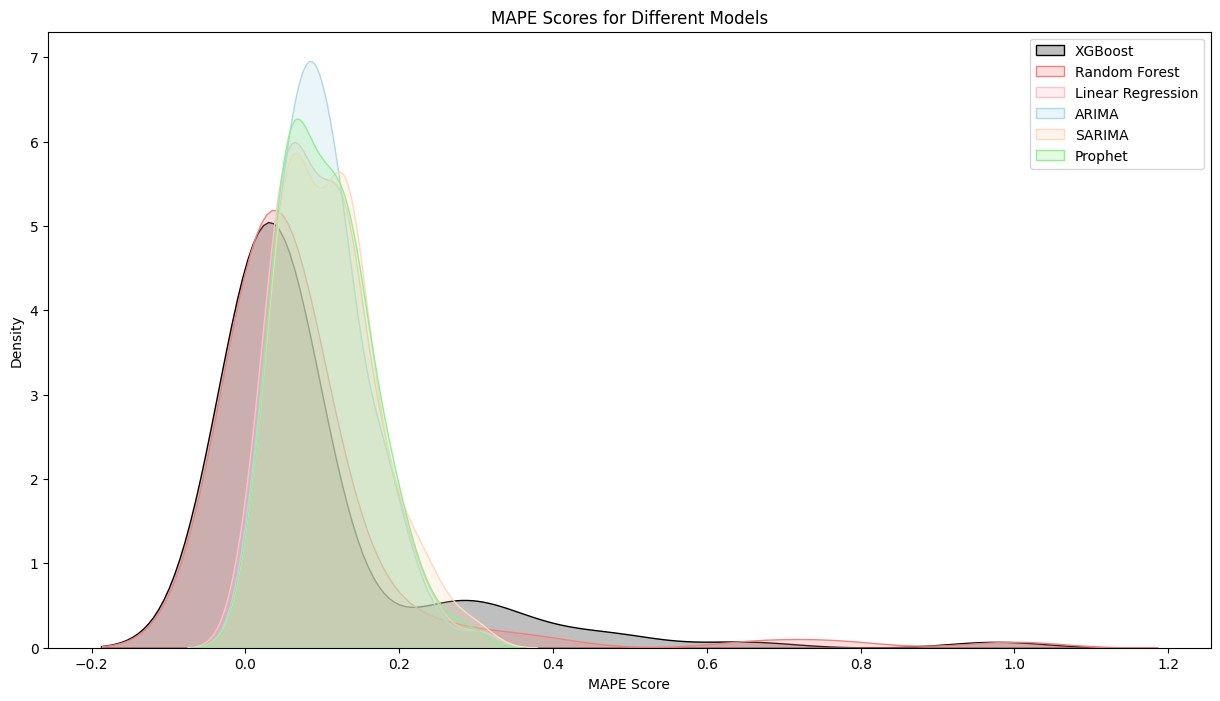

In [40]:
# plotting line plot for 6 models with respect to pizza's mape score
plt.figure(figsize=(15, 8))

colors = {
    'ARIMA': 'lightblue',
    'SARIMA': 'peachpuff',
    'Prophet': 'lightgreen',
    'Linear Regression': 'pink',
    'Random Forest': 'lightcoral',
    'XGBoost': 'black'
}

for model, scores in results.items():
    #pizza = list(scores.keys())
    mape = list(scores.values())
    sns.kdeplot(mape, label=model, color=colors[model],fill=True)

plt.title('MAPE Scores for Different Models')
plt.xlabel('MAPE Score')  # Corrected label
plt.ylabel('Density')
plt.legend()
plt.show()

In [41]:
# Create future dates for the next 7 days
Sales_Prediction = pd.date_range(start=P_Sales['order_date'].max(), periods=8, freq='D')[1:]

# Create a DataFrame for future sales
Sales_Prediction = pd.DataFrame({'order_date': Sales_Prediction})

# Add time-based features
Sales_Prediction['week_number'] = Sales_Prediction['order_date'].dt.isocalendar().week
Sales_Prediction['month_number'] = Sales_Prediction['order_date'].dt.month
Sales_Prediction['week_day_number'] = Sales_Prediction['order_date'].dt.dayofweek

# Make predictions for each pizza type
predictions = {}
for pizza_id, df in pizza_dfs.items():
    model = PizzaSalesModeling(df)
    trained_model = model.xgboost_model()  
    X_future = np.arange(len(df), len(df) + len(Sales_Prediction)).reshape(-1, 1)  
    predictions[pizza_id] = trained_model.predict(X_future)  

# Convert predictions to DataFrame
predicted_sales = pd.DataFrame(predictions, index=Sales_Prediction['order_date'])
print("Predicted Sales for Next Week:")
predicted_sales


Predicted Sales for Next Week:


,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
order_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-02,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-03,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-04,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-05,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-06,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207
2016-01-07,1.250159,1.002669,1.000117,1.004119,1.000362,1.000087,1.000457,1.000073,1.004307,1.001846,...,1.000324,1.000151,1.000101,1.000165,1.000069,1.001581,1.0,1.001472,1.000754,1.000207


In [42]:
# Grouping ingredient quantities per pizza
P_Ingredients_Grouped = P_Ingredients.groupby(['pizza_name_id', 'pizza_ingredients'])['Items_Qty_In_Grams'].sum().reset_index()

# Merging predicted sales with ingredient data
ingredient_sales = predicted_sales.sum().reset_index()
ingredient_sales.columns = ['pizza_name_id', 'Total_Predicted_Sales']

# Merge with ingredient quantities per pizza
merged_data = P_Ingredients_Grouped.merge(ingredient_sales, on='pizza_name_id', how='inner')

# Compute total ingredient quantity required
merged_data['Total_Quantity_grams'] = merged_data['Items_Qty_In_Grams'] * merged_data['Total_Predicted_Sales']

# Aggregate ingredient quantities
ingredient_needs_df = merged_data.groupby('pizza_ingredients')['Total_Quantity_grams'].sum().reset_index()
ingredient_needs_df['Total_Quantity_kg'] = ingredient_needs_df['Total_Quantity_grams'] / 1000               # Convert to kg

# Round off to 2 decimal places 
ingredient_needs_df['Total_Quantity_grams'] = ingredient_needs_df['Total_Quantity_grams'].round(2)
ingredient_needs_df['Total_Quantity_kg'] = ingredient_needs_df['Total_Quantity_kg'].round(2)

# Display final ingredient requirements
print("Required Ingredient Quantities for Next Week:")
ingredient_needs_df


Required Ingredient Quantities for Next Week:


,pizza_ingredients,Total_Quantity_grams,Total_Quantity_kg
0,?duja Salami,840.17,0.84
1,Alfredo Sauce,315.11,0.32
2,Anchovies,595.34,0.60
3,Artichokes,2051.77,2.05
4,Arugula,210.10,0.21
...,...,...,...
59,Sun-dried Tomatoes,490.00,0.49
60,Thai Sweet Chilli Sauce,420.89,0.42
61,Thyme,35.01,0.04
62,Tomatoes,8832.02,8.83


In [43]:
# Saving the ingredient_needs_df to a csv file
path =r"D:/Mirthu/Dominos/Purchase_Ingredients.csv"
ingredient_needs_df.to_csv(path, index=False)